# Práctica Final Large Language Models

## Autor: Manuel Pérez Perdomo.

In [1]:
import os, getpass
from dotenv import load_dotenv

# Intenta cargar las variables desde el archivo .env
dotenv_loaded = load_dotenv()

api_key_names = {
    "OpenAI API key": "OPENAI_API_KEY",
    "Google Gemini API key": "GOOGLE_API_KEY",
    "LangSmith API key": "LANGSMITH_API_KEY",
    "Tavily API key": "TAVILY_API_KEY",
}

# Solicita las claves si no están definidas
for key, value in api_key_names.items():
    if not os.getenv(value):
        os.environ[value] = getpass.getpass(f"🔑 {key}: ")
    
    if not os.getenv(value):
        raise RuntimeError(f"❌ No se encontró la API key '{value}'. Por favor, agrégala al archivo .env o introdúcela manualmente.")

print("✅ Claves cargadas en variables de entorno.")

✅ Claves cargadas en variables de entorno.


In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults(max_results=2)
search_results = search.invoke("¿Qué tiempo hace en Tenerife, Canarias?")
print(search_results)
# Si quisiéramos, podríamos crear otras herramientas.
# Una vez tengamos todas las herramientas que queremos, podemos ponerlas en una lista que usaremos más tarde.
tools = [search]

/Users/user/large_language_models/practica-final-llm/venv/lib/python3.14/site-packages/langchain_core/_api/deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1
/var/folders/dr/ny159j891p789_yb5kxk3fb40000gn/T/ipykernel_21289/3554332350.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  search = TavilySearchResults(max_results=2)


[{'title': 'El tiempo en Tenerife - Clima y mejor época para viajar a ...', 'url': 'https://www.disfrutatenerife.com/tiempo', 'content': 'Civitatis   Tenerife\n\n1. Información general\n2. Planifica tu viaje\n\n# El tiempo en Tenerife\n\nTenerife es uno de los destinos con más horas de sol de Europa. Esta isla canaria se caracteriza por sus temperaturas suaves durante todo el año y por los fuertes contrastes entre el norte y el sur. ¿Sabíais que hay unos 25 microclimas en Tenerife?\n\nLa temperatura de Tenerife es suave durante prácticamente todo el año y no presenta cambios bruscos entre estaciones. Las temperaturas medias rondan los 25°C en verano y los 18°C en invierno, aunque la presencia de microclimas hace que existan pequeñas variaciones térmicas constantes. [...] ## Tenerife en invierno\n\nEl invierno es la época favorita de los turistas para viajar a Tenerife. En comparación con el resto de los destinos europeos, las islas Canarias ofrecen buen tiempo todo el año, por lo que s

## Carga de datos.

In [2]:
from langchain_community.document_loaders import PyPDFLoader

# Ruta al PDF local
pdf_path = "data/Tenerife.pdf"

# Crear el loader
loader = PyPDFLoader(pdf_path)

# Cargar el documento
docs = loader.load()

# Comprobaciones y salida
assert len(docs) >= 1, "At least one document should be loaded."
print(f"PDF loaded with {sum(len(d.page_content) for d in docs)} characters.")
print(f"Number of pages loaded: {len(docs)}")

/Users/user/large_language_models/practica-final-llm/venv/lib/python3.14/site-packages/langchain_core/_api/deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


PDF loaded with 16094 characters.
Number of pages loaded: 25


In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    add_start_index=True
)
all_splits = text_splitter.split_documents(docs)

print(f"Total splits: {len(all_splits)}")

# Mostramos el primer split.
print(f"First split content:\n{all_splits[0].page_content}\n")

Total splits: 30
First split content:
TENERIFE – LUGARES DE INTERÉS 
SITIOS QUE VER 
 
ZONA NORTE 
 
• Santa Cruz de Tenerife: 
Santa Cruz de Tenerife es la capital de la isla. Quizás la ruta a seguir si vais a Santa 
Cruz sería: 
- Aparcar en el aparcamiento del Parque Marítimo (ubicación). 
- Caminar por la Avenida Marítima hasta Plaza de España (ubicación). 
- Por el camino de la Avenida Marítima, ver el auditorio de Tenerife (ubicación). 
- Una vez llegados a Plaza España, callejear un poco (subir la Calle Castillo 
dirección Plaza Weyler - ubicación –; ir hacia el Parque García Sanabria - 
ubicación -; y bajar de nuevo hacia Plaza de España pasando por la Plaza del 
Príncipe - ubicación). 
- Volver de nuevo a por el coche. 
- Ir hacia la playa de Las Teresitas (ubicación). 
Los puntos de interés sugeridos son estos: 
o Parque Marítimo César Manrique [vídeo - ubicación] 
Conjunto de piscinas naturales.



### Modelo de embeddings de Google.

In [4]:
import getpass
import os

from dotenv import load_dotenv
load_dotenv()

if not os.environ.get("GOOGLE_API_KEY"):
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [5]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['f90fda00-ff6a-4bee-999b-88d57ba81526', '01374f21-2c8f-4f79-8174-2b8aaaa3d1ad', '9ebf7a65-bd1f-4c3a-b342-0db581f15092']


## Interacción multiturno con LLM.

In [6]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

In [8]:
from langgraph.graph import START, StateGraph
from langgraph.graph import MessagesState

graph_builder = StateGraph(MessagesState)

In [9]:
from langchain_core.tools import tool

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [11]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode

# Paso 1: Generar el AIMessage que puede incluir una tool-call. 
def query_or_respond(state: MessagesState): 
    """Generate tool call for retrieval or respond directly.""" 
    llm_with_tools = llm.bind_tools([retrieve]) 
    response = llm_with_tools.invoke(state["messages"]) 
    # MessagesState añade los mensajes al estado en lugar de sobrescribirlos. 
    return {"messages": [response]} 
# Paso 2: Ejecutar la tool si es necesario. 
tools = ToolNode([retrieve])

def generate(state: MessagesState):
    """Generate final answer as a commercial tour guide for Tenerife."""

    # 1️⃣ Recuperamos los mensajes de tipo ToolMessage
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # 2️⃣ Contexto recuperado por RAG
    docs_content = "\n\n".join(doc.content for doc in tool_messages)

    # 3️⃣ System prompt especializado
    system_message_content = (
        "You are a professional and friendly tourist guide specialized in the island of Tenerife. "
        "Your goal is to help users plan their trip and recommend places, activities, and experiences "
        "in an engaging and commercial way.\n\n"
        "Do NOT make up facts or locations. "
        "If the information is not present, say that you don't know.\n\n"
        "Adapt your recommendations to the user's interests when possible "
        "(nature, beaches, culture, gastronomy, family, adventure, etc.).\n\n"
        "Keep answers concise (maximum 4 sentences), friendly, and informative.\n\n"
        "Retrieved context:\n"
        f"{docs_content}"
    )

    # 4️⃣ Mensajes de conversación (multiturno)
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]

    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # 5️⃣ Generar respuesta
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [12]:
from langgraph.graph import END
from langgraph.prebuilt import tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

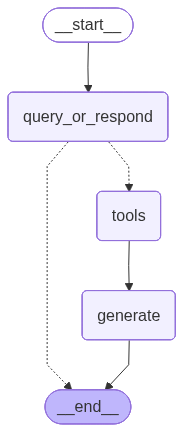

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
input_message = "Which are the most famous places in Tenerife?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which are the most famous places in Tenerife?
================================== Ai Message ==================================
Tool Calls:
  retrieve (ac73b1b6-d5ad-4366-8557-d5967462bb7c)
 Call ID: ac73b1b6-d5ad-4366-8557-d5967462bb7c
  Args:
    query: most famous places in Tenerife
================================= Tool Message =================================
Name: retrieve

Source: {'producer': 'PyPDF', 'creator': 'Microsoft Word', 'creationdate': '2025-07-13T20:00:01+00:00', 'title': 'Microsoft Word - TENERIFE.docx', 'moddate': '2025-07-13T20:00:01+00:00', 'source': 'data/Tenerife.pdf', 'total_pages': 25, 'page': 14, 'page_label': '15', 'start_index': 0}
Content: • El Teide 
Si vais a Tenerife y no subís al Parque Nacional del Teide, simplemente no habéis 
estado en Tenerife. 
 
Mi recomendación – esto es simplemente gustos personales míos – para subir al 
Teide es subir por la carretera TF24 (carr